In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
from scipy import signal
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from scipy import stats
from sklearn.model_selection import train_test_split

In [2]:
fn = "822e26/responseTiming-5.mat"
fin = h5py.File(fn, "r")
mat = {}
for k, raw_v in fin.items():
    v = {}
    for k2, v2 in raw_v.items():
        if k2 == 'info':
            l = {}
            for k3, v3 in v2.items():
                l[k3] = np.array(v3)
            v[k2] = l
        else:
            v[k2] = np.array(v2)
    mat[k] = v


In [3]:
mat.keys()

dict_keys(['#refs#', 'ECO1', 'ECO2', 'ECO3', 'IPIc', 'IPIs', 'Info', 'NPul', 'PAmp', 'PTDc', 'PTDt', 'PWcd', 'PWsm', 'PWus', 'Sing', 'Stim', 'Tact', 'Tick', 'Tra1', 'Tra2', 'Trg1', 'Trg2', 'Trg3', 'Valu'])

In [4]:
fsTact = mat['Tact']['info']['SamplingRateHz'][0][0]
fsEEG = mat['ECO1']['info']['SamplingRateHz'][0][0]
t = np.arange(0,len(mat['Tact']['data'][0]))
onset = mat['PAmp']['onset']
offset = mat['PAmp']['offset']

Text(0.5, 1.0, 'tactile')

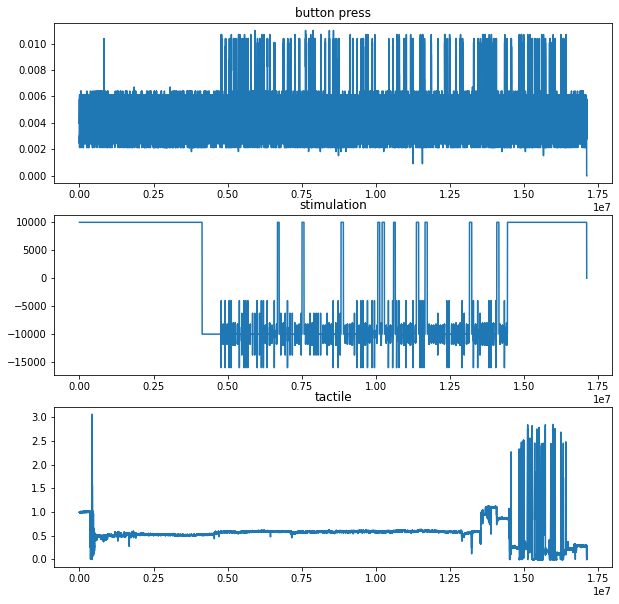

In [5]:
fig, axs = plt.subplots(3, 1, figsize = (10, 10))

button = mat['Tact']['data'][1,:]
axs[0].plot(t, button)
axs[0].set_title('button press')
# axs[0].plot(t, [0.009] * len(t))

stim = np.sum(mat['Sing']['data'][:3, :], axis=0)
stim[np.where(stim == 30000)] = 0
axs[1].plot(t, stim)
axs[1].set_title('stimulation')

tactile = mat['Tact']['data'][0,:]
axs[2].plot(t, tactile)
axs[2].set_title('tactile')
# axs[1].plot(t, [2] * len(t))

In [6]:
buttonPressRaw = mat['Tact']['data'][1]
buttonPressRawInds = np.where(buttonPressRaw >= 0.008)[0]
buttonPressDiff = np.diff(buttonPressRawInds)
buttonPressDiffSec = buttonPressDiff/fsTact
buttonPressDiffInds = np.where(buttonPressDiffSec >= 1)[0]

buttonPressInds = np.zeros(len(buttonPressDiffInds) + 1, dtype=int)
buttonPressInds[0] = buttonPressRawInds[0]
for i, diffInd in enumerate(buttonPressDiffInds):
    buttonPressInds[i + 1] = buttonPressRawInds[diffInd] + buttonPressDiff[diffInd]

buttonPressIndsSec = buttonPressInds/fsTact
buttonPressBinarized = np.zeros(len(buttonPressRaw), dtype=int)
buttonPressBinarized[buttonPressInds] = 1

In [7]:
tactOnsetRaw = mat['Tact']['data'][0]
tactOnsetRawInds = np.where(tactOnsetRaw >= 1.5)[0]
tactOnsetDiff = np.diff(tactOnsetRawInds)
tactOnsetDiffSec = tactOnsetDiff/fsTact
tactOnsetDiffInds = np.where(tactOnsetDiffSec >= 1)[0]

tactOnsetInds = np.zeros(len(tactOnsetDiffInds) + 1, dtype=int)
tactOnsetInds[0] = tactOnsetRawInds[0]
for i, diffInd in enumerate(tactOnsetDiffInds):
    tactOnsetInds[i + 1] = tactOnsetRawInds[diffInd] + tactOnsetDiff[diffInd]

In [8]:
stimOnsetInds = [np.round(x) for x in onset * fsTact][0]
stimOnsetInds = np.array([int(x) for x in stimOnsetInds])

In [9]:
stimReactionTimes = np.zeros(len(stimOnsetInds))
stimPressedInds = np.zeros(len(stimOnsetInds), dtype=int)
for i in range(len(stimReactionTimes)):
    x = np.where(buttonPressBinarized[stimOnsetInds[i]:]==1)[0]
    if len(x) > 0:
        rt = x[0]/fsTact
        if rt < offset[0][i] - onset[0][i]:
            stimReactionTimes[i] = rt
            stimPressedInds[i] = x[0] + stimOnsetInds[i]
#         else:
#             stimPressedInds[i] = int(np.round(offset[0][i] * fsTact))
#     else:
#         if offset[0][i] != np.inf:
#             stimPressedInds[i] = int(np.round(offset[0][i] * fsTact))

In [10]:
tactReactionTimes = np.zeros(len(tactOnsetInds))
tactPressedInds = np.zeros(len(tactOnsetInds), dtype=int)
for i in range(len(tactOnsetInds)):
    x = np.where(buttonPressBinarized[tactOnsetInds[i]:]==1)[0]
    if len(x) > 0:
        rt = x[0]/fsTact
        if rt < offset[0][i] - onset[0][i]:
            tactReactionTimes[i] = rt
            tactPressedInds[i] = x[0] + tactOnsetInds[i]

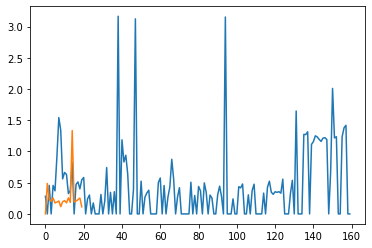

In [11]:
plt.plot(stimReactionTimes)
plt.plot(tactReactionTimes)

In [12]:
conds = {}
conds[(0.0)] = 0
conds[(2.0, 3750.0)] = 1
conds[(40.0, 2000.0)] = 2
conds[(40.0, 1600.0)] = 3
conds[(40.0, 1790.0)] = 4
conds[(40.0, 750.0)] = 5
conds[(40.0, 1250.0)] = 6
condIndex = 7

In [13]:
PAmp = mat['PAmp']['data'][0]
NPul = mat['NPul']['data'][0]
for i in range(len(PAmp)):
    if NPul[i] != 0:
        if (NPul[i], PAmp[i]) not in conds:
            conds[(NPul[i], PAmp[i])] = condIndex
            condIndex += 1

In [14]:
conds

{0.0: 0,
 (2.0, 3750.0): 1,
 (40.0, 2000.0): 2,
 (40.0, 1600.0): 3,
 (40.0, 1790.0): 4,
 (40.0, 750.0): 5,
 (40.0, 1250.0): 6}

In [15]:
stimConds = {}
for i in range(len(PAmp)):
    tup = (NPul[i], PAmp[i])
    if NPul[i] == 0:
        c = 0
    else:
        c = conds[tup]
    if c in stimConds:
        stimConds[c].append(i)
    else:
        stimConds[c] = [i]

In [16]:
stimConds

{6: [0,
  9,
  12,
  19,
  22,
  31,
  54,
  64,
  65,
  67,
  76,
  80,
  81,
  90,
  102,
  103,
  114,
  122,
  124,
  128],
 4: [1,
  3,
  8,
  14,
  26,
  36,
  39,
  40,
  51,
  58,
  59,
  82,
  94,
  97,
  101,
  104,
  105,
  111,
  115,
  126],
 5: [2,
  4,
  5,
  11,
  13,
  17,
  20,
  25,
  52,
  62,
  69,
  70,
  78,
  84,
  87,
  91,
  92,
  109,
  116,
  121],
 2: [6,
  7,
  23,
  29,
  34,
  42,
  50,
  53,
  60,
  66,
  73,
  83,
  86,
  106,
  108,
  118,
  119,
  120,
  123,
  129],
 1: [10,
  15,
  16,
  18,
  28,
  30,
  32,
  33,
  37,
  41,
  43,
  44,
  45,
  46,
  49,
  55,
  61,
  98,
  110,
  117],
 3: [21,
  24,
  35,
  47,
  48,
  57,
  63,
  68,
  71,
  75,
  77,
  85,
  88,
  95,
  96,
  99,
  100,
  107,
  112,
  127],
 0: [27,
  38,
  56,
  72,
  74,
  79,
  89,
  93,
  113,
  125,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154

In [17]:
tactList = []
for i in range(len(tactOnsetInds)):
    tactList.append([tactOnsetInds[i], -1])
    tactList[i].append(tactReactionTimes[i])
    tactList[i].append(tactPressedInds[i])

stimList = []
for i in range(len(stimOnsetInds)):
    stimCondKeys = list(stimConds.keys())
    cond = 0
    while i not in stimConds[stimCondKeys[cond]]:
        cond += 1
    stimList.append([stimOnsetInds[i], stimCondKeys[cond]])
    stimList[i].append(stimReactionTimes[i])
    stimList[i].append(stimPressedInds[i])

allStimsList = tactList.copy()
allStimsList.extend(stimList)
allStimsList = sorted(allStimsList)

In [18]:
allStimsList

[[414927, -1, 0.0, 0],
 [4782488, 6, 0.28172288, 4789366],
 [4846502, 4, 0.0, 0],
 [4914091, 5, 0.45568, 4925216],
 [4981421, 4, 0.0, 0],
 [5050553, 5, 0.4562944, 5061693],
 [5115305, 5, 0.36978688, 5124333],
 [5184836, 2, 0.91328512, 5207133],
 [5248841, 2, 1.5427584, 5286506],
 [5331462, 4, 1.33902336, 5364153],
 [5394799, 6, 0.56119296, 5408500],
 [5478540, 1, 0.66408448, 5494753],
 [5549317, 5, 0.63275008, 5564765],
 [5611509, 6, 0.32526336, 5619450],
 [5680903, 5, 0.37486592, 5690055],
 [5759906, 4, 0.82202624, 5779975],
 [5840342, 1, 0.0, 0],
 [5914680, 1, 0.47345664, 5926239],
 [5992468, 5, 0.51187712, 6004965],
 [6075320, 1, 0.40116224, 6085114],
 [6137693, 6, 0.54632448, 6151031],
 [6206142, 5, 0.58343424, 6220386],
 [6268305, 3, 0.0, 0],
 [6334112, 6, 0.23965696, 6339963],
 [6412729, 2, 0.30212096, 6420105],
 [6491385, 3, 0.0, 0],
 [6573851, 5, 0.1755136, 6578136],
 [6649106, 4, 0.0, 0],
 [6711867, 0, 0.0, 0],
 [6795430, 1, 0.0, 0],
 [6876005, 2, 0.31105024, 6883599],
 [69440

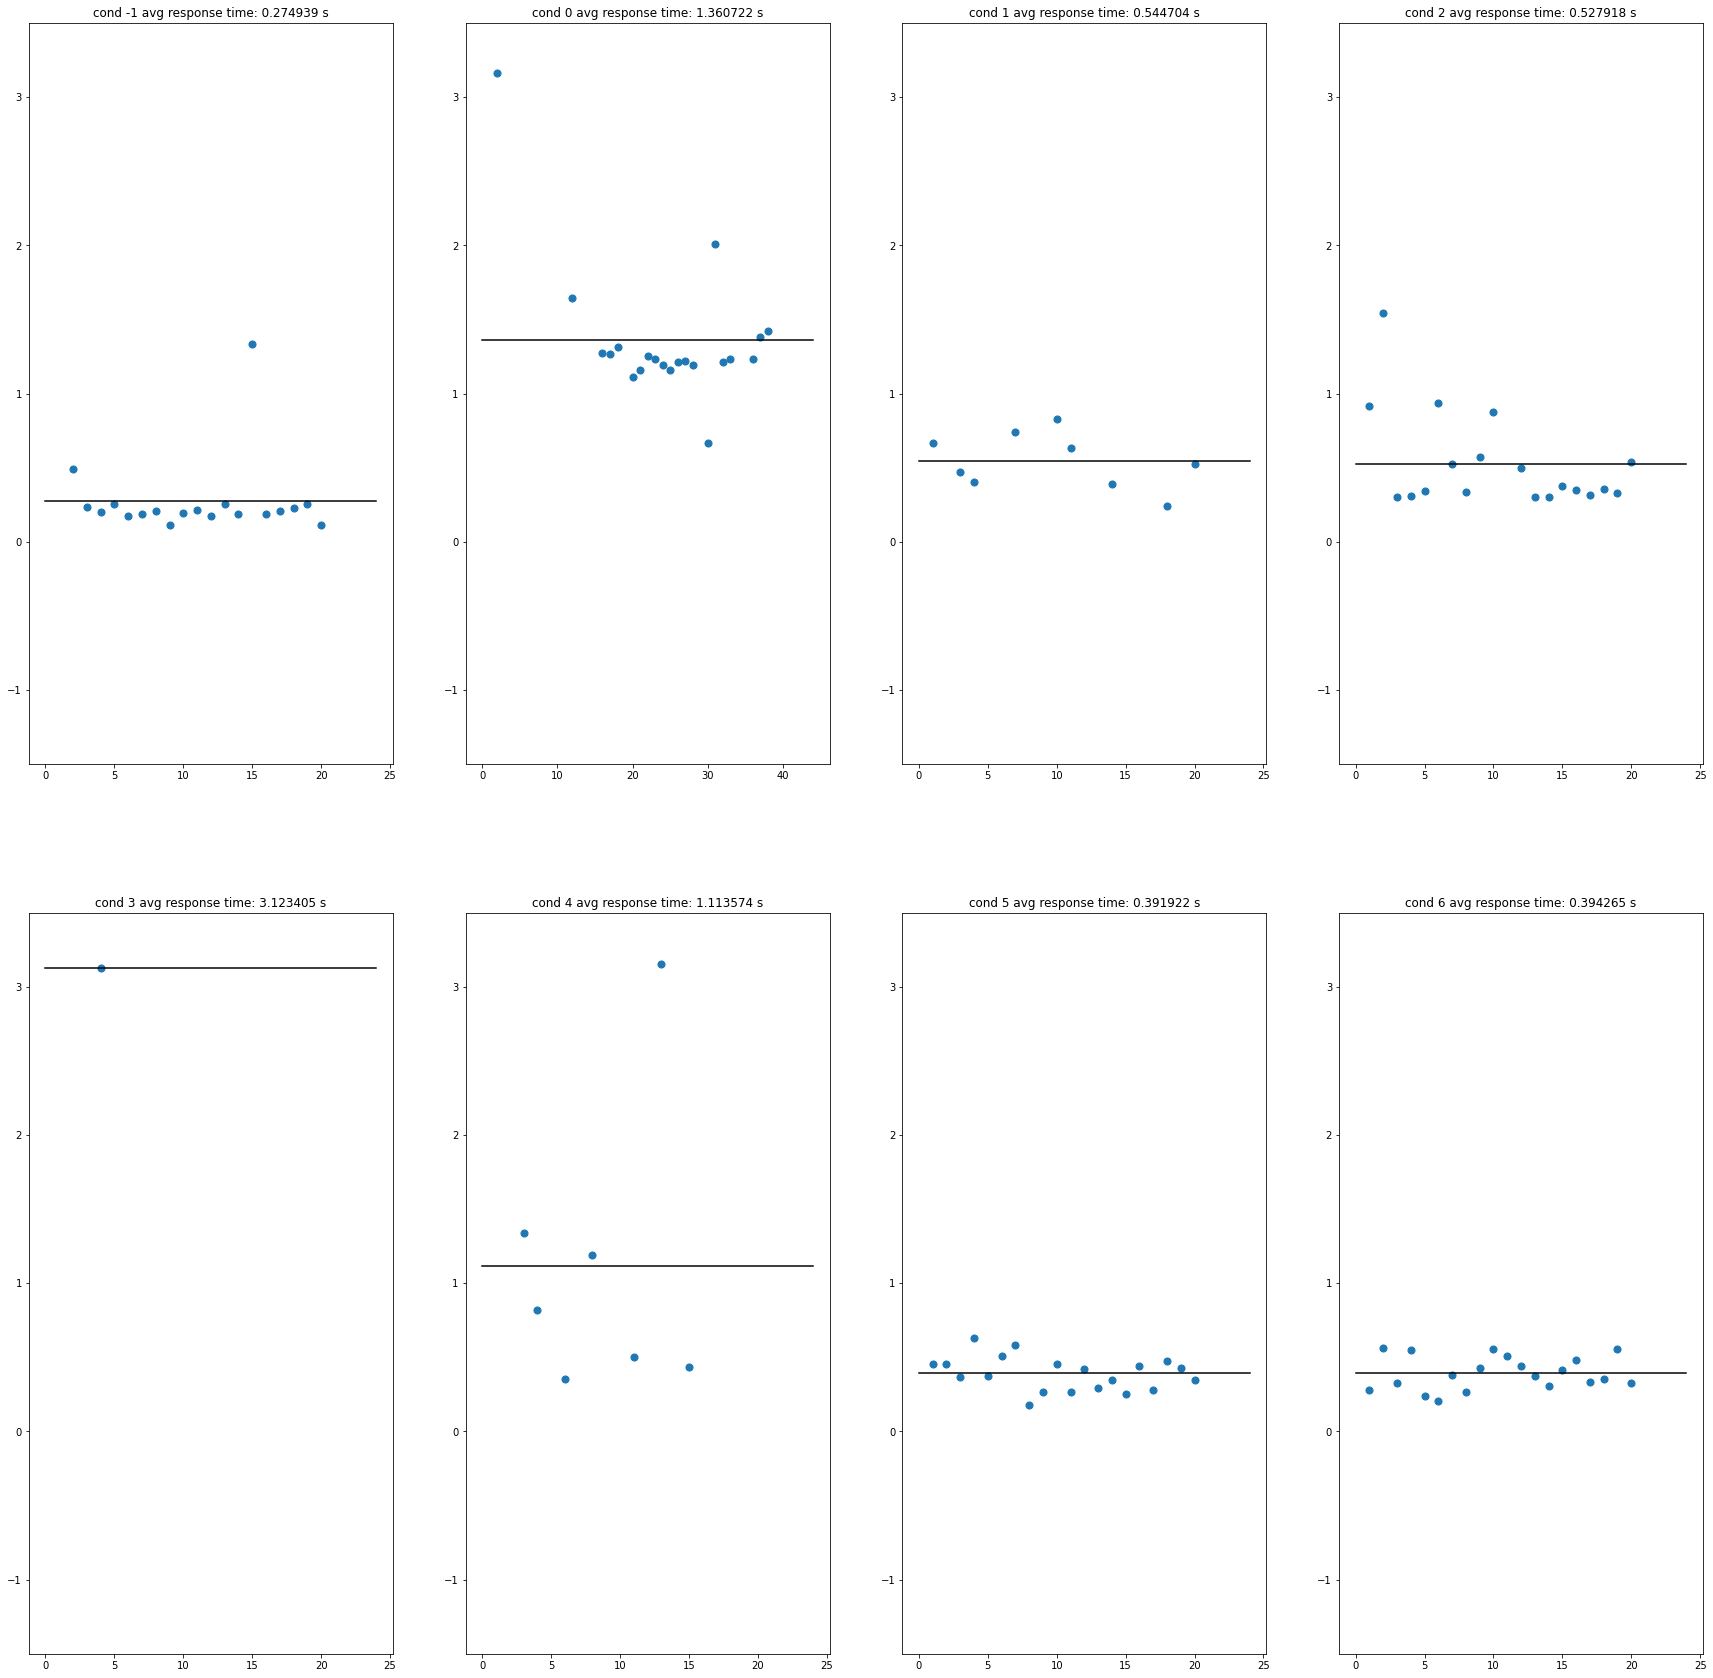

In [19]:
fig, axs = plt.subplots(2, 4, figsize = (30, 30))
s = 50
for i in range(2):
    for j in range(4):
        cond = -1
        if i == 0 and j == 0:
            plotting = tactReactionTimes
        else:
            cond = i*4 + j - 1
            plotting = stimReactionTimes[stimConds[cond]]
        
        trials = list(range(1,len(plotting)+1))
        x = []
        y = []
        for k in range(len(plotting)):
            if plotting[k] != 0:
                y.append(plotting[k])
                x.append(trials[k])
        axs[i, j].scatter(x, y, s=s)
        axs[i, j].plot([np.mean(y)] * (len(plotting)+5), 'k')
#         axs[i, j].set_xlim([0,21])
        axs[i, j].set_ylim([-1.5, 3.5])
        axs[i, j].set_title('cond %i avg response time: %f s' % (cond, np.mean(y)))


In [20]:
rawEEGSignals = np.concatenate((mat['ECO1']['data'], mat['ECO2']['data'], mat['ECO3']['data']))

In [21]:
fsConversion = fsEEG/fsTact
for i in range(len(allStimsList)):
    if allStimsList[i][3] > allStimsList[i][0]:
        startInd = int(allStimsList[i][0] * fsConversion)
        endInd = int((allStimsList[i][3]) * fsConversion)
        allStimsList[i].append(rawEEGSignals[:, startInd:endInd])
    else:
        allStimsList[i].append([])

In [22]:
df = pd.DataFrame(allStimsList, columns = ['startInd', 'cond', 'reactionTime', 'endInd', 'EEG'])
dfPresses = df.loc[df['reactionTime'] != 0]
dfPresses = dfPresses.reset_index()
dfPresses = dfPresses.drop('index', axis = 1)
dfPresses.head()

startInd  cond  reactionTime   endInd  \
0   4782488     6      0.281723  4789366   
1   4914091     5      0.455680  4925216   
2   5050553     5      0.456294  5061693   
3   5115305     5      0.369787  5124333   
4   5184836     2      0.913285  5207133   

                                                 EEG  
0  [[-2.6239997623633826e-06, -5.567999778577359e...  
1  [[-1.0175999705097638e-05, -9.439999303140212e...  
2  [[1.4735998774995096e-05, 1.2367999261186924e-...  
3  [[7.679999498577672e-07, 3.4079998840752523e-0...  
4  [[-9.279999176214915e-06, -1.25599990496994e-0...

In [23]:
dfPresses.loc[dfPresses['cond']==-1].head()

startInd  cond  reactionTime    endInd  \
78  14557063    -1      0.488325  14568985   
80  14829766    -1      0.234414  14835489   
82  14904826    -1      0.202793  14909777   
84  14979387    -1      0.255427  14985623   
86  15117859    -1      0.175677  15122148   

                                                  EEG  
78  [[2.307199792994652e-05, 2.3343998691416346e-0...  
80  [[-4.207999609207036e-06, -6.943999778741272e-...  
82  [[-5.02399961987976e-06, -1.2959999367012642e-...  
84  [[-1.358399913442554e-05, -1.3295999451656826e...  
86  [[-1.2351999430393334e-05, -1.3407999176706653...

In [24]:
stimChannels = np.array([61, 62])
s1Channels = np.array([60, 52, 44, 36, 28])
m1Channels = np.array([61, 53, 45, 37, 29])

order = 2
delta = signal.butter(order, [0.1, 4], 'bp', fs=fsEEG, output='sos')
theta = signal.butter(order, [4, 8], 'bp', fs=fsEEG, output='sos')
alpha = signal.butter(order, [8, 12], 'bp', fs=fsEEG, output='sos')
beta = signal.butter(order, [12, 30], 'bp', fs=fsEEG, output='sos')
gamma = signal.butter(order, [30, 60], 'bp', fs=fsEEG, output='sos')
high_gamma = signal.butter(order, [60, 120], 'bp', fs=fsEEG, output='sos')
neural = signal.butter(order, [0.1, 200], 'bp', fs=fsEEG, output='sos')

bands = [delta, theta, alpha, beta, gamma, high_gamma]
band_names = ["delta", "theta", "alpha", "beta", "gamma", "high gamma"]

In [25]:
def smoothArtifacts(sig, stimArtifactInds, peakRange, repairRange):
    n = len(sig)
    for peakInd in stimArtifactInds:
        useRight = False
        repairValLeft = np.mean(sig[max(peakInd-peakRange-repairRange,0):max(peakInd-peakRange,0)])
        if peakInd <= peakRange:
            repairValLeft = np.mean(sig[:peakInd])
            if peakInd == 0:
                useRight = True
        
        repairValRight = np.mean(sig[min(peakInd+peakRange,n-1):min(peakInd+peakRange+repairRange,n)])
        if peakInd + peakRange > n-1:
            repairValRight = np.mean(sig[peakInd+1:])
            if peakInd == n-1:
                repairValRight = repairValLeft
        
        if useRight:
            repairValLeft = repairValRight
        
        sig[max(peakInd-peakRange,0):peakInd] = repairValLeft
        sig[peakInd:min(peakInd+peakRange,n)] = repairValRight
    return sig

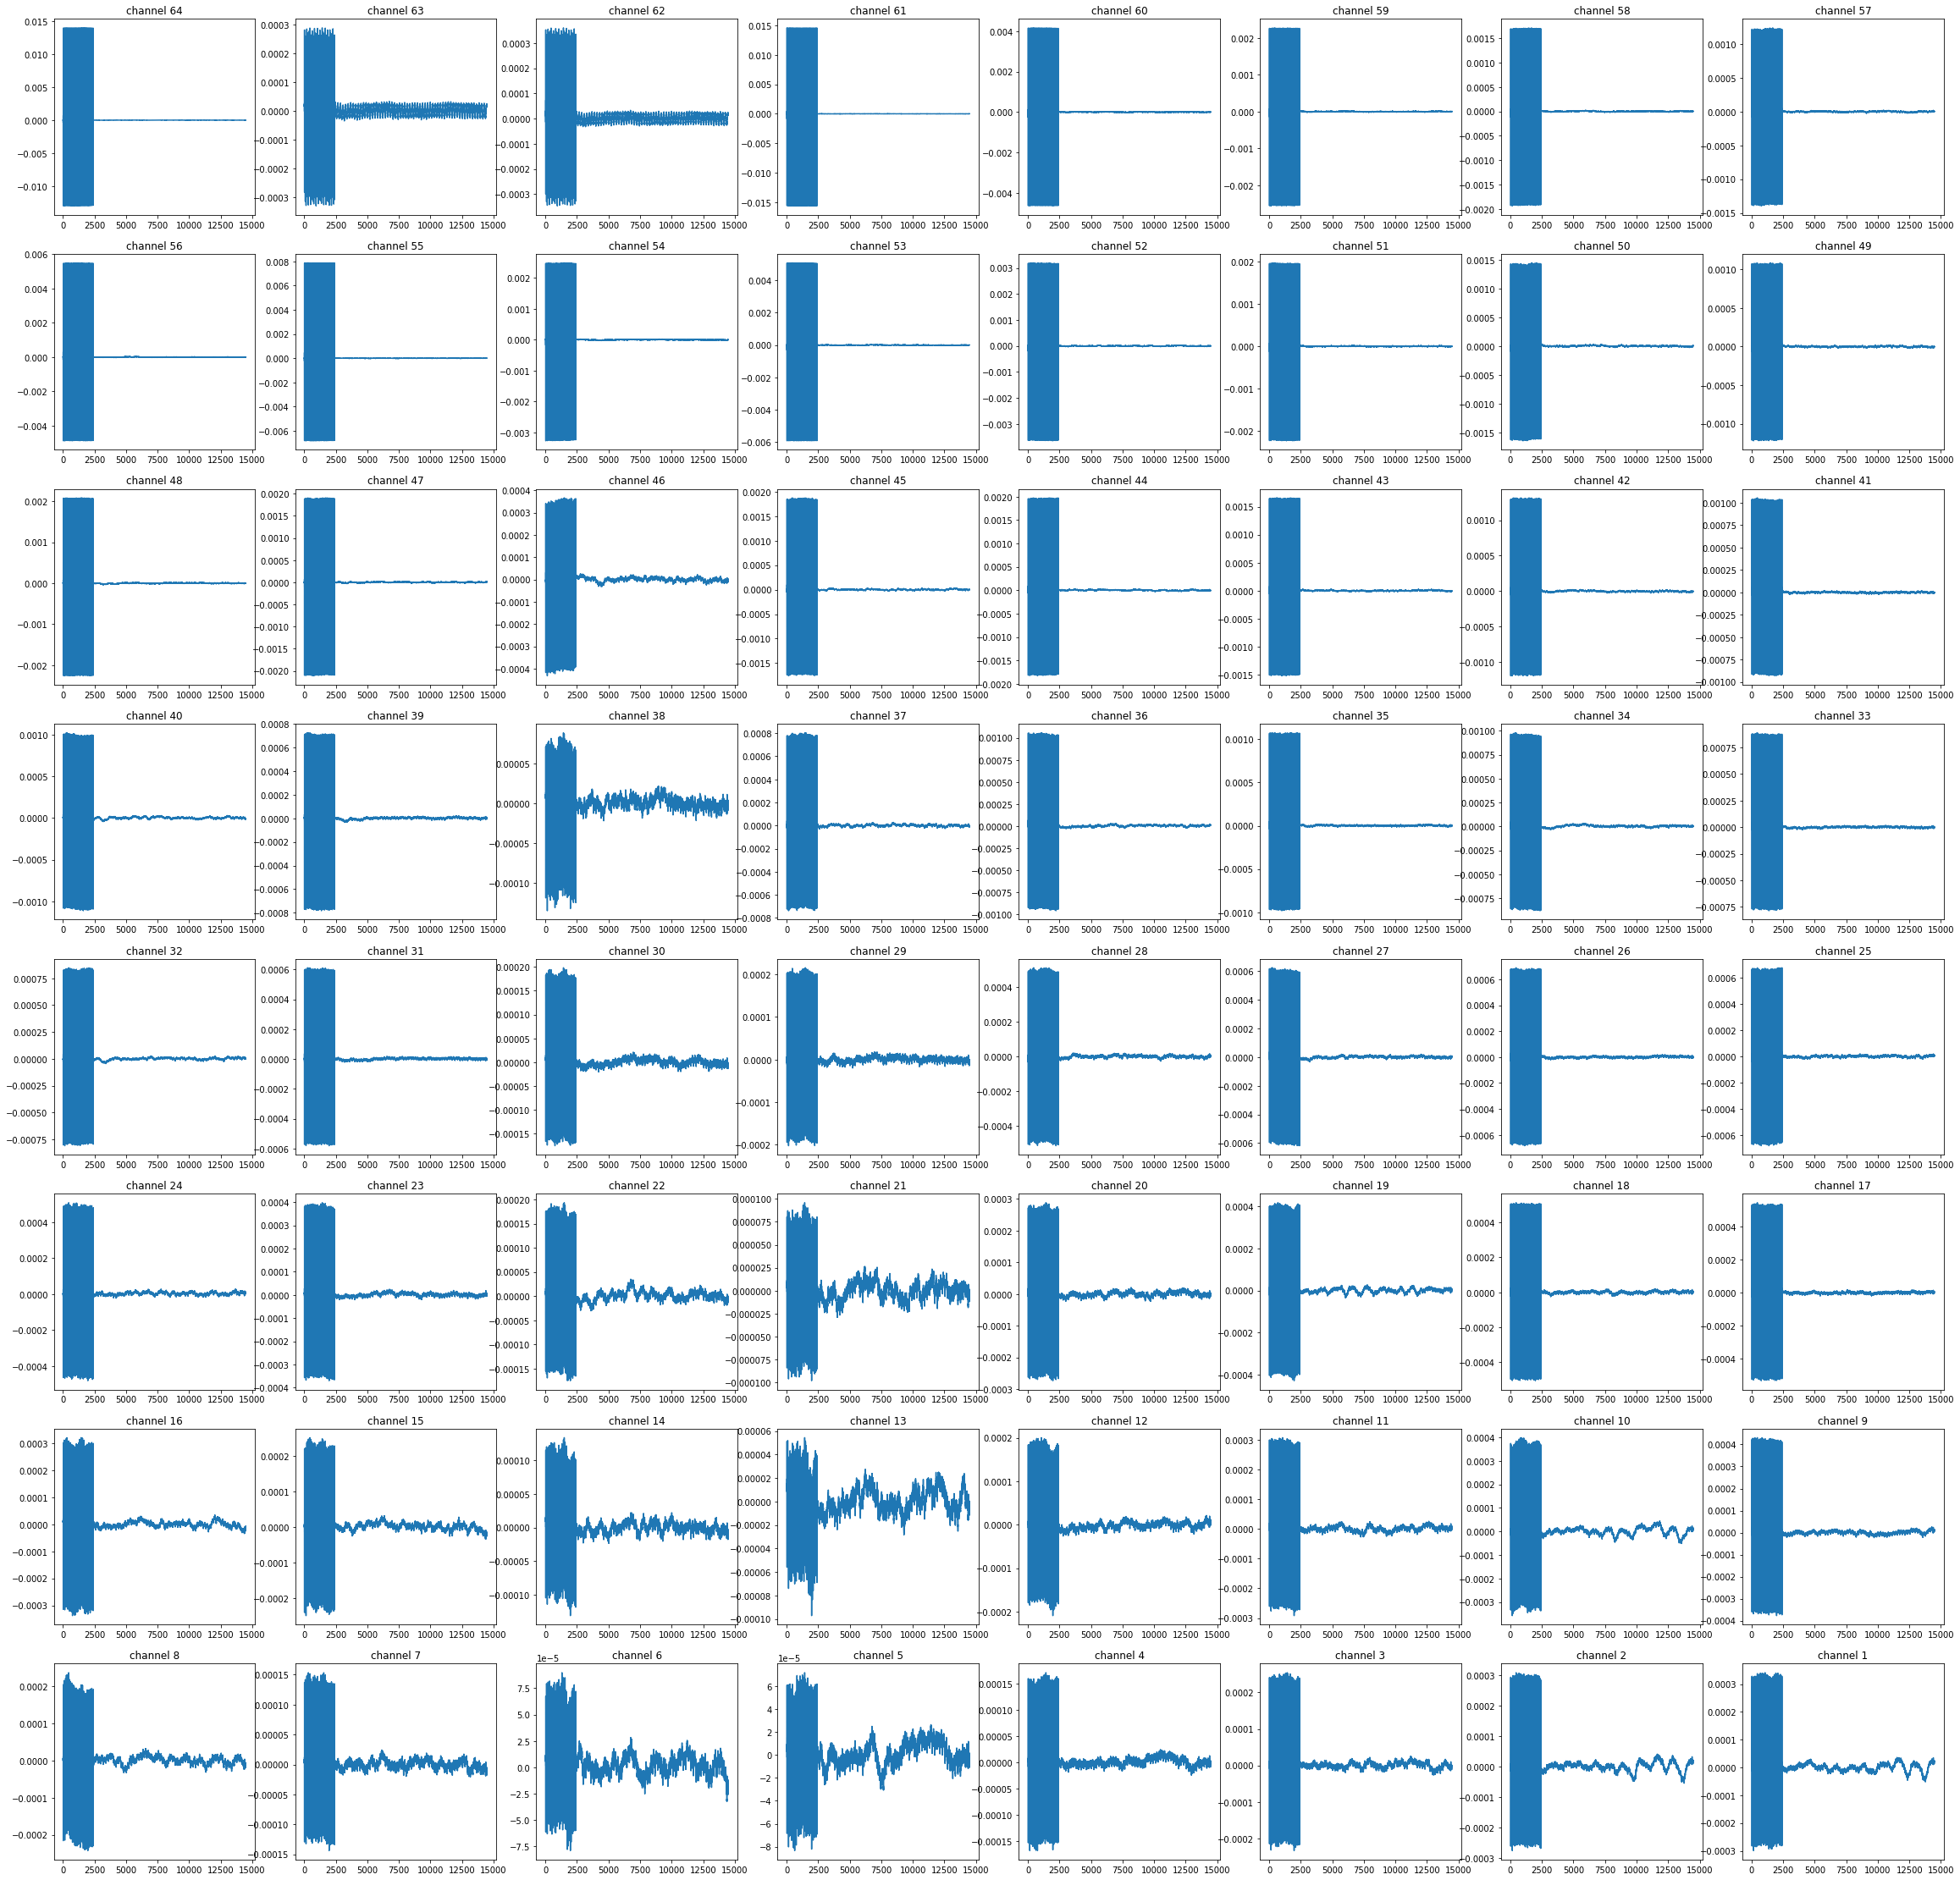

In [26]:
fig, axs = plt.subplots(8, 8, figsize = (40, 40))

trial = 27
ch = 0

for i in range(8):
    for j in range(8):
        axs[i, j].plot(dfPresses['EEG'][trial][63 - (i*8 + j)])
        axs[i, j].set_title('channel %i' % (63 - (i*8 + j) + 1))
        ch += 1

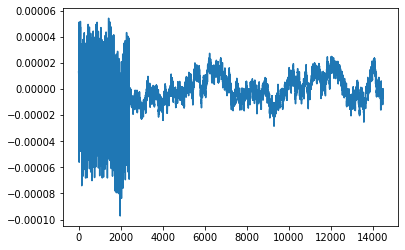

In [27]:
plt.plot(np.copy(dfPresses['EEG'][trial][12]))

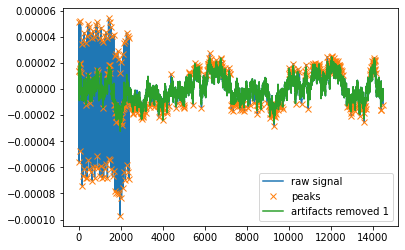

In [28]:
channel = 12
sig = np.copy(dfPresses['EEG'][trial][channel])
posInds,_ = signal.find_peaks(sig, distance=10, height=(np.mean(sig) + np.std(sig)))
negInds,_ = signal.find_peaks(-sig, distance=10, height=(np.mean(-sig) + np.std(-sig)))
stimArtifactInds = np.concatenate((posInds, negInds))
plt.plot(sig, label='raw signal')
plt.plot(stimArtifactInds, sig[stimArtifactInds], 'x', label='peaks')

peakRange = 3
repairRange = 6
sig = smoothArtifacts(sig, stimArtifactInds, peakRange, repairRange)
plt.plot(sig, label = 'artifacts removed 1')
plt.legend()

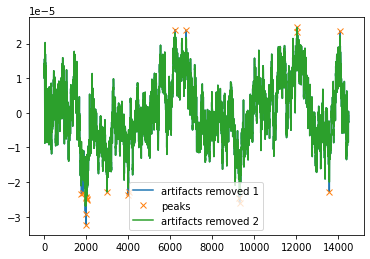

In [29]:
if(dfPresses['cond'][trial] > 0):
    posInds,_ = signal.find_peaks(sig, distance=10, height=(np.mean(sig) + 2.5*np.std(sig)))
    negInds,_ = signal.find_peaks(-sig, distance=10, height=(np.mean(-sig) + 2.5*np.std(-sig)))
    stimArtifactInds = np.concatenate((posInds, negInds))
    plt.plot(sig, label='artifacts removed 1')
    plt.plot(stimArtifactInds, sig[stimArtifactInds],'x', label='peaks')

    peakRange = 3
    repairRange = int(len(sig)/100)
    sig = smoothArtifacts(sig, stimArtifactInds, peakRange, repairRange)

    plt.plot(sig, label = 'artifacts removed 2')
else:
    plt.plot(sig, label='artifacts removed 1')

plt.legend()

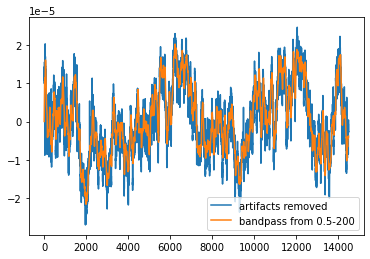

In [30]:
plt.plot(sig, label="artifacts removed")
neuralSignal = signal.sosfilt(neural, sig)
plt.plot(neuralSignal, label="bandpass from 0.5-200")
plt.legend()

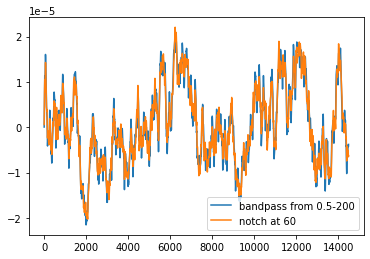

In [31]:
b_notch, a_notch = signal.iirnotch(60, 30, fsEEG)
notchNeuralSignal = signal.filtfilt(b_notch, a_notch, neuralSignal)
plt.plot(neuralSignal, label="bandpass from 0.5-200")
plt.plot(notchNeuralSignal, label = "notch at 60")
plt.legend()

In [32]:
def filterSignal(s):
    sig = np.copy(s)
    posInds,_ = signal.find_peaks(sig, distance=10, height=(np.mean(sig) + np.std(sig)))
    negInds,_ = signal.find_peaks(-sig, distance=10, height=(np.mean(-sig) + np.std(-sig)))
    stimArtifactInds = np.concatenate((posInds, negInds))

    peakRange = 3
    repairRange = 6
    sig = smoothArtifacts(sig, stimArtifactInds, peakRange, repairRange)
    
    posInds,_ = signal.find_peaks(sig, distance=10, height=(np.mean(sig) + 2.5*np.std(sig)))
    negInds,_ = signal.find_peaks(-sig, distance=10, height=(np.mean(-sig) + 2.5*np.std(-sig)))
    stimArtifactInds = np.concatenate((posInds, negInds))

    repairRange = int(len(sig)/100)
    sig = smoothArtifacts(sig, stimArtifactInds, peakRange, repairRange)
    
    neuralSignal = signal.sosfilt(neural, sig)
    b_notch, a_notch = signal.iirnotch(60, 30, fsEEG)
    notchNeuralSignal = signal.filtfilt(b_notch, a_notch, neuralSignal)
    
    return notchNeuralSignal

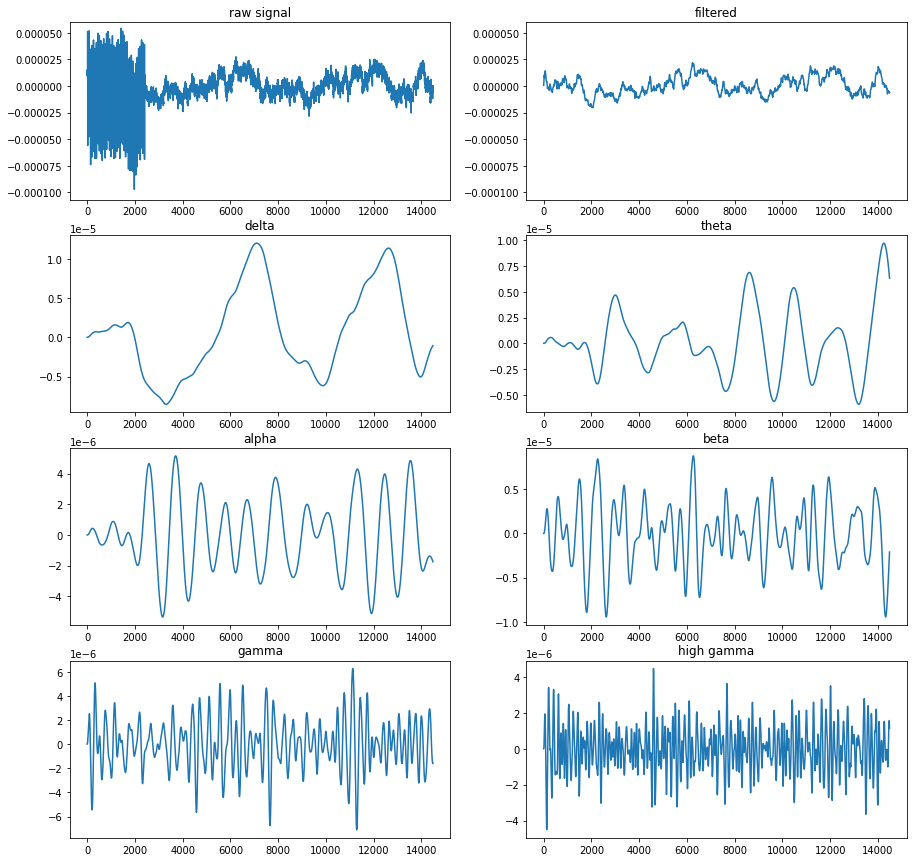

In [37]:
fig, axs = plt.subplots(4, 2, figsize = (15, 15))

channel = 12
sig = dfPresses['EEG'][trial][channel]
axs[0,0].plot(sig)
axs[0,0].set_title('raw signal')
axs[0,0].set_ylim((np.min(sig)*1.1, np.max(sig)*1.1))

filteredSig = filterSignal(sig)
axs[0,1].plot(filteredSig)
axs[0,1].set_title('filtered')
axs[0,1].set_ylim((np.min(sig)*1.1, np.max(sig)*1.1))

for b in range(len(bands)):
    bandSig = signal.sosfilt(bands[b], filteredSig)
    axs[b//2+1, b%2].plot(bandSig)
    axs[b//2+1, b%2].set_title(band_names[b])
#     axs[b//2+1, b%2].set_ylim((np.min(sig)*1.1, np.max(sig)*1.1))

Text(0.5, 1.0, 'spectral density')

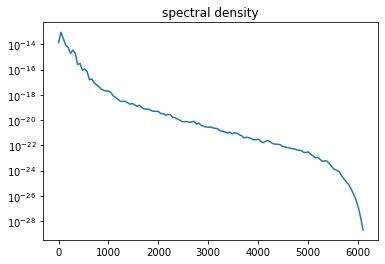

In [38]:
f, Pxx = signal.welch(filteredSig, fsEEG)
plt.semilogy(f, Pxx)
# plt.xlim([0.1, 200])
plt.title('spectral density')

In [39]:
dfPresses['filtered by cond'] = [[0]] * len(dfPresses)

chs = [i for i in range(64) if i not in stimChannels]

for cond in np.unique(dfPresses['cond']):
    
    minCond = float('inf')
    condDf = dfPresses.loc[dfPresses['cond']==cond]
    
    for sigs in condDf['EEG']:
            if len(sigs[0]) < minCond:
                minCond = len(sigs[0])
    
    inds = condDf.index
    for i, sigs in enumerate(condDf['EEG']):
        condSigs = []
        for ch in chs:
            sig = sigs[ch][:minCond]
            filteredSig = filterSignal(sig)
            condSigs.append(filteredSig)
        else:
            condSigs.append([])
        dfPresses.at[inds[i], 'filtered by cond'] = np.asarray(condSigs)

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Us

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

In [40]:
# bandsTact = []
# for sig in tactSigs:
#     bandsTact.append(signal.sosfilt(beta, sig))

# fig, axs = plt.subplots(5, 4, figsize = (15, 15))
# for i in range(5):
#     for j in range(4):
#         if i==4 and j==3:
#             break
#         axs[i,j].plot(bandsTact[i*4 + j])
#         axs[i,j].set_ylim((np.min(bandsTact)*1.1,np.max(bandsTact)*1.1))
# plt.show()
# tactBand = np.mean(bandsTact, axis=0)
# plt.plot(tactBand, 'r.')
# plt.errorbar(np.arange(len(tactBand))[::10], tactBand[::10], yerr=np.std(bandsTact, axis=0)[::10], c='b')

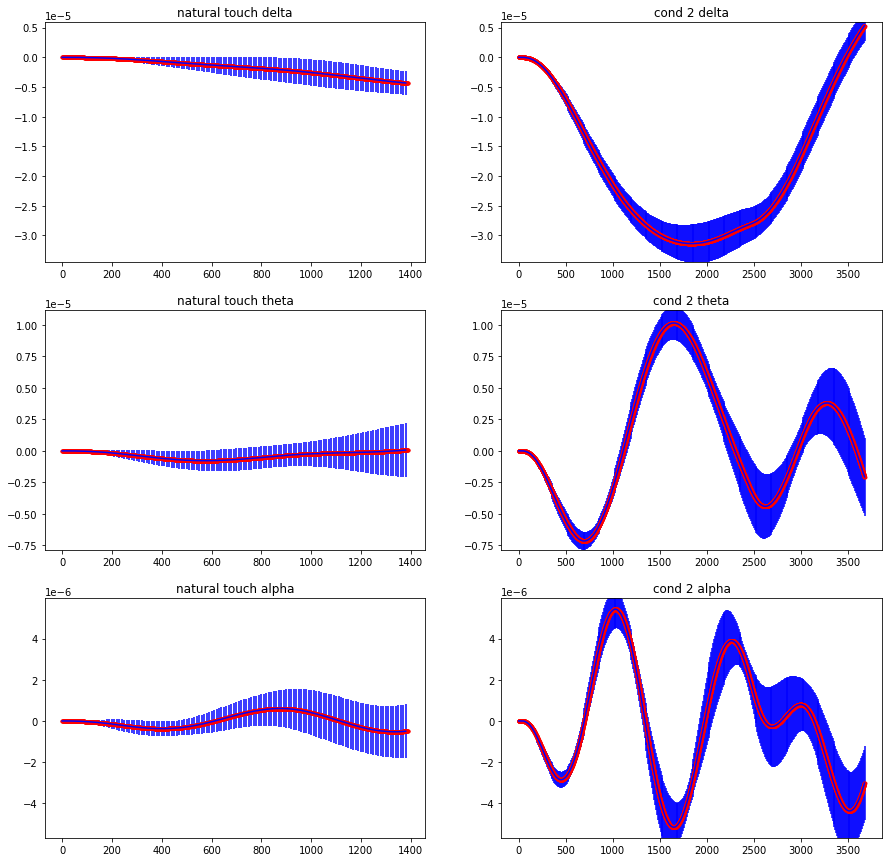

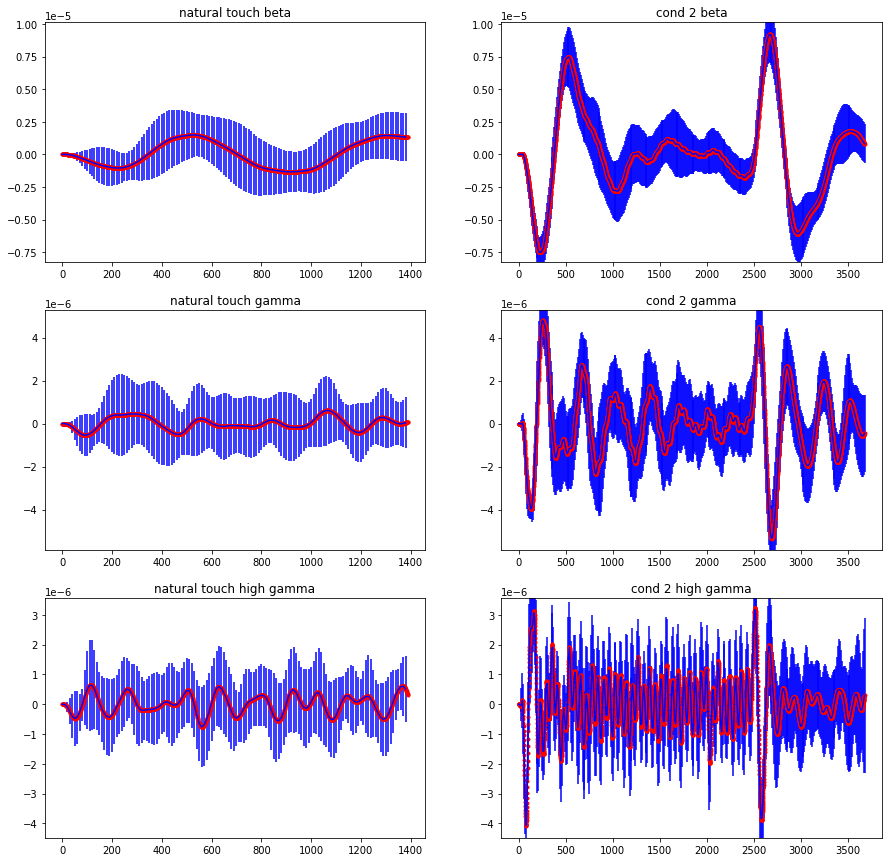

In [41]:
channel = 60
averagedBands = []

cond1 = -1
cond2 = 2

for b in range(len(bands)):
    if b%3 == 0:
        fig, axs = plt.subplots(3, 2, figsize = (15, 15))
    
    bandsTact = []
    for sigs in dfPresses.loc[dfPresses['cond']==cond1]['filtered by cond']:
        bandsTact.append(signal.sosfilt(bands[b], sigs[channel]))
    
    bandsCond = []
    for sigs in dfPresses.loc[dfPresses['cond']==cond2]['filtered by cond']:
        bandsCond.append(signal.sosfilt(bands[b], sigs[channel]))
    
    tactBand = np.mean(bandsTact, axis=0)
    condBand = np.mean(bandsCond, axis=0)
    averagedBands.append([tactBand, condBand])
    
    axs[b%3, 0].set_title('natural touch ' + band_names[b])
    axs[b%3, 0].errorbar(np.arange(len(tactBand))[::10], tactBand[::10], yerr=np.std(bandsTact, axis=0)[::10], c='b')
    axs[b%3, 0].plot(tactBand, 'r.')
    axs[b%3, 0].set_ylim((np.min(np.concatenate((tactBand,condBand)))*1.1, np.max(np.concatenate((tactBand,condBand)))*1.1))
    
    title = 'cond ' + str(cond2) + ' ' + band_names[b]
    axs[b%3, 1].set_title(title)
    axs[b%3, 1].errorbar(np.arange(len(condBand))[::10], condBand[::10], yerr=np.std(bandsCond, axis=0)[::10], c='b')
    axs[b%3, 1].plot(condBand, 'r.')
    axs[b%3, 1].set_ylim((np.min(np.concatenate((tactBand,condBand)))*1.1, np.max(np.concatenate((tactBand,condBand)))*1.1))

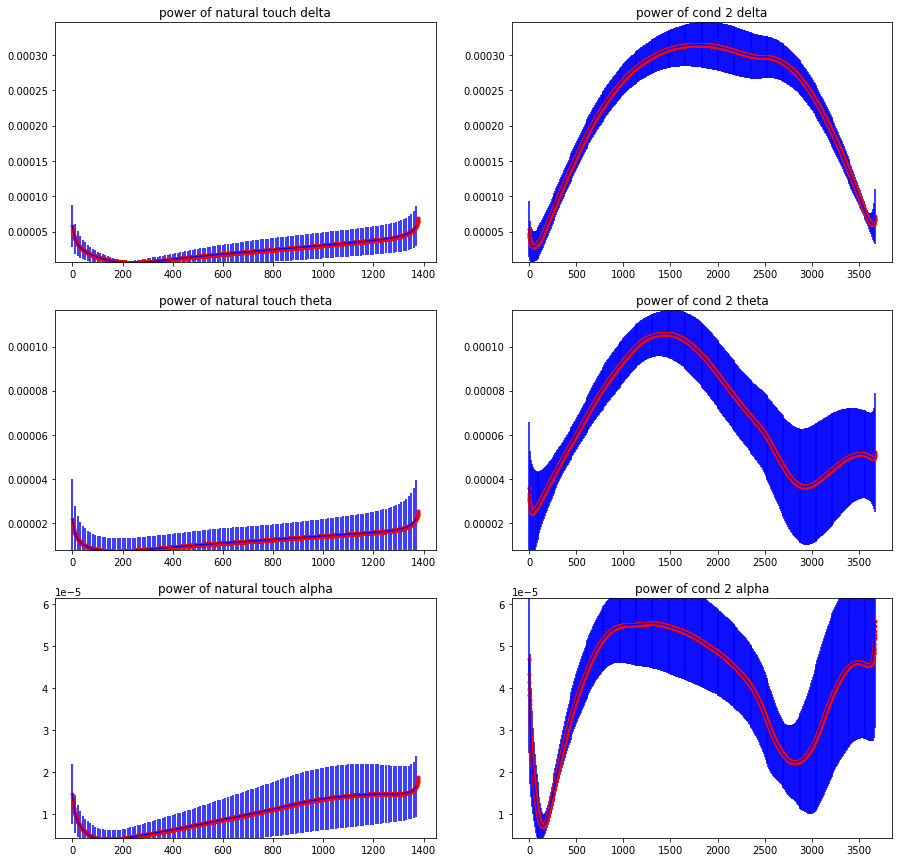

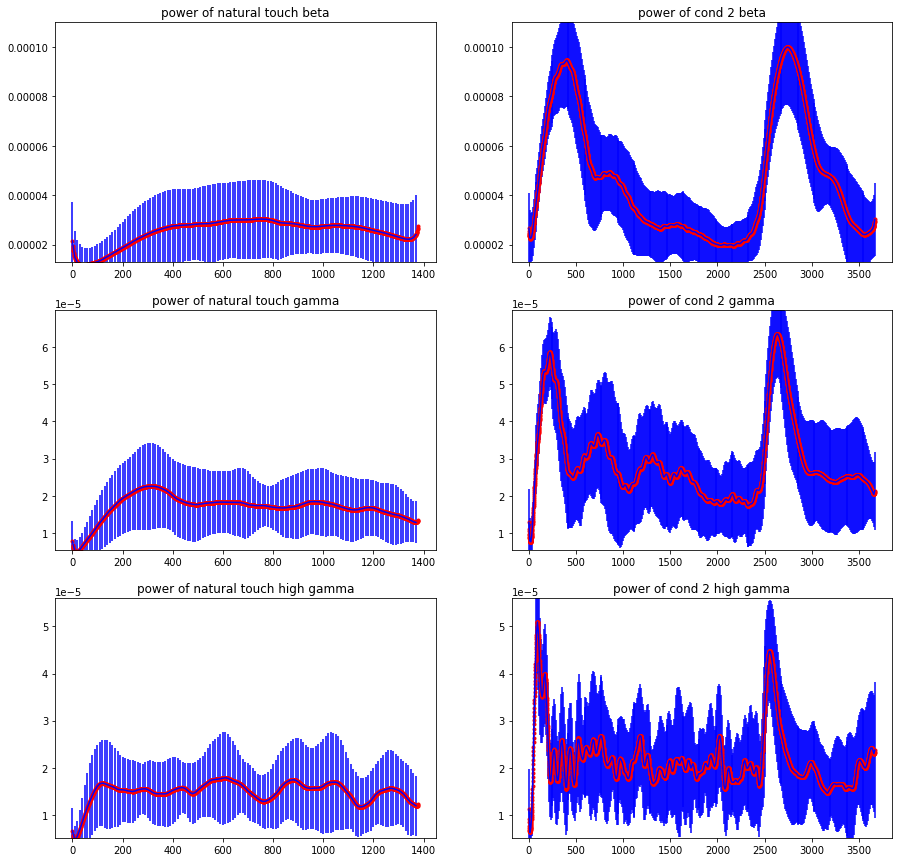

In [42]:
averagedPowerBands = []
window = 10

for b in range(len(bands)):
    if b%3 == 0:
        fig, axs = plt.subplots(3, 2, figsize = (15, 15))
    
    bandsPowerTact = []
    for sigs in dfPresses.loc[dfPresses['cond']==cond1]['filtered by cond']:
        band_signal = signal.sosfilt(bands[b], sigs[channel])
        hilbert_signal = signal.hilbert(band_signal)
        hilbert_signal = np.abs(hilbert_signal)
        p = []
        for i in range(len(hilbert_signal) - window):
            p.append(np.sum(hilbert_signal[i:i+window]))
        bandsPowerTact.append(p)
        
    bandsPowerCond = []
    for sigs in dfPresses.loc[dfPresses['cond']==cond2]['filtered by cond']:
        band_signal = signal.sosfilt(bands[b], sigs[channel])
        hilbert_signal = signal.hilbert(band_signal)
        hilbert_signal = np.abs(hilbert_signal)
        p = []
        for i in range(len(hilbert_signal) - window):
            p.append(np.sum(hilbert_signal[i:i+window]))
        bandsPowerCond.append(p)
    
    tactBand = np.mean(bandsPowerTact, axis=0)
    condBand = np.mean(bandsPowerCond, axis=0)
    averagedPowerBands.append([tactBand, condBand])
    
    axs[b%3, 0].set_title('power of natural touch ' + band_names[b])
    axs[b%3, 0].errorbar(np.arange(len(tactBand))[::10], tactBand[::10], yerr=np.std(bandsPowerTact, axis=0)[::10], c='b')
    axs[b%3, 0].plot(tactBand, 'r.')
    axs[b%3, 0].set_ylim((np.min(np.concatenate((tactBand,condBand)))*1.1, np.max(np.concatenate((tactBand,condBand)))*1.1))
    
    title = 'power of cond ' + str(cond2) + ' ' + band_names[b]
    axs[b%3, 1].set_title(title)
    axs[b%3, 1].errorbar(np.arange(len(condBand))[::10], condBand[::10], yerr=np.std(bandsPowerCond, axis=0)[::10], c='b')
    axs[b%3, 1].plot(condBand, 'r.')
    axs[b%3, 1].set_ylim((np.min(np.concatenate((tactBand,condBand)))*1.1, np.max(np.concatenate((tactBand,condBand)))*1.1))

In [43]:
def t_test(v1, v2, cond1, cond2, show=False):
    if len(v1) < 3 or len(v2) < 3:
        return float('inf')
    if show:
        sns.distplot(v1, label="cond " + str(cond1))
        sns.distplot(v2, label="cond " + str(cond2))
        plt.suptitle("difference in features between conditions", y=1.05, fontsize=18)
        plt.legend()
    
    norm1 = stats.shapiro(v1)[1]
    norm2 = stats.shapiro(v2)[1]
    if show:
        print("p-value of shapiro test of v1 is %f and v2 is %f" % (norm1, norm2))

    bar = stats.bartlett(v1, v2)[1]
    if show:
        print("p-value for equal variances is %f" % bar)

    ev = bar > 0.05
    tt = stats.ttest_ind(v1, v2, equal_var = ev)
    
    if show:
        print("t-test: t-statistic is %f and p-value is %f" % tt)
        if tt[1] < 0.05:
            print("statistically significant difference")
            plt.title("p-value is %f, statistically significant difference" % tt[1])
        else:
            print("not a statistically significant difference")
            plt.title("p-value is %f, not a statistically significant difference" % tt[1])
    else:
        return tt[1]

5


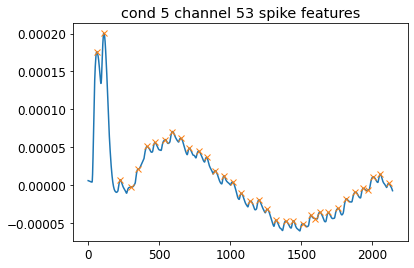

In [44]:
plt.rcParams.update({'font.size': 12})
sigs = dfPresses['filtered by cond'][3]
ch = 53
spikeInds,_ = signal.find_peaks(sigs[ch], distance=len(sigs[ch])//100)
plt.plot(sigs[ch])
plt.plot(spikeInds, sigs[ch][spikeInds], 'x')
plt.title('cond 5 channel 53 spike features')
print(dfPresses['cond'][3])

In [45]:
features = []
labels = []
# chs = np.array([64,63,62,61,60,55,54,53,46]) - 1
chs = [i for i in range(64) if i not in stimChannels]

for cond in np.unique(dfPresses['cond']):
    for sigs in dfPresses.loc[dfPresses['cond']==cond]['filtered by cond']:
        f = []
        for ch in range(len(chs)):
            for b in bands:
                band_signal = signal.sosfilt(b, sigs[ch])
                hilbert_signal = signal.hilbert(band_signal)
                f.append(np.sum(np.abs(hilbert_signal))/len(sigs[ch]))
            spikeInds,_ = signal.find_peaks(sigs[ch], distance=len(sigs[ch])//100)
            if len(spikeInds)==0:
                f.append(0)
                f.append(0)
                f.append(0)
            else:
                f.append(len(spikeInds)/len(sigs[ch]))
                f.append(np.mean(sigs[ch][spikeInds]))
                if len(spikeInds)==1:
                    f.append(0)
                else:
                    f.append(np.mean(np.diff(spikeInds)))
            

        features.append(f)
        labels.append(cond)

# for b in range(len(featureNames)):
#     dist = len(list(pd.core.common.flatten([y[b::len(featureNames)] for y in features])))
#     for i in range(len(features)):
#         for ch in range(len(chs)):
#             features[i][b + ch*len(featureNames)] = (features[i][b + ch*len(featureNames)] - np.mean(dist))/np.max(dist)

features = np.asarray(features)
labels = np.asarray(labels)

# featureNames = ["percentage of spikes", "average spike amplitude", "average distance between spikes"]
# featureNames = ["delta power", "theta power", "alpha power", "beta power", "gamma power", "high gamma power"]
featureNames = ["delta power", "theta power", "alpha power", "beta power", "gamma power", "high gamma power", "percentage of spikes", "average spike amplitude", "average distance between spikes"]

In [46]:
pValsMatrix = []
for b in range(len(featureNames)):
    pVM = []
    for cond1 in np.unique(dfPresses['cond']):
        x = []
        for cond2 in np.unique(dfPresses['cond']):
            v1 = []
            v2 = []
            
            v1 = list(pd.core.common.flatten([y[b::len(featureNames)] for y in features[np.where(labels==cond1)[0]]]))
            v2 = list(pd.core.common.flatten([y[b::len(featureNames)] for y in features[np.where(labels==cond2)[0]]]))

            x.append(t_test(v1, v2, cond1, cond2, False))
        pVM.append(x)
    pValsMatrix.append(pVM)

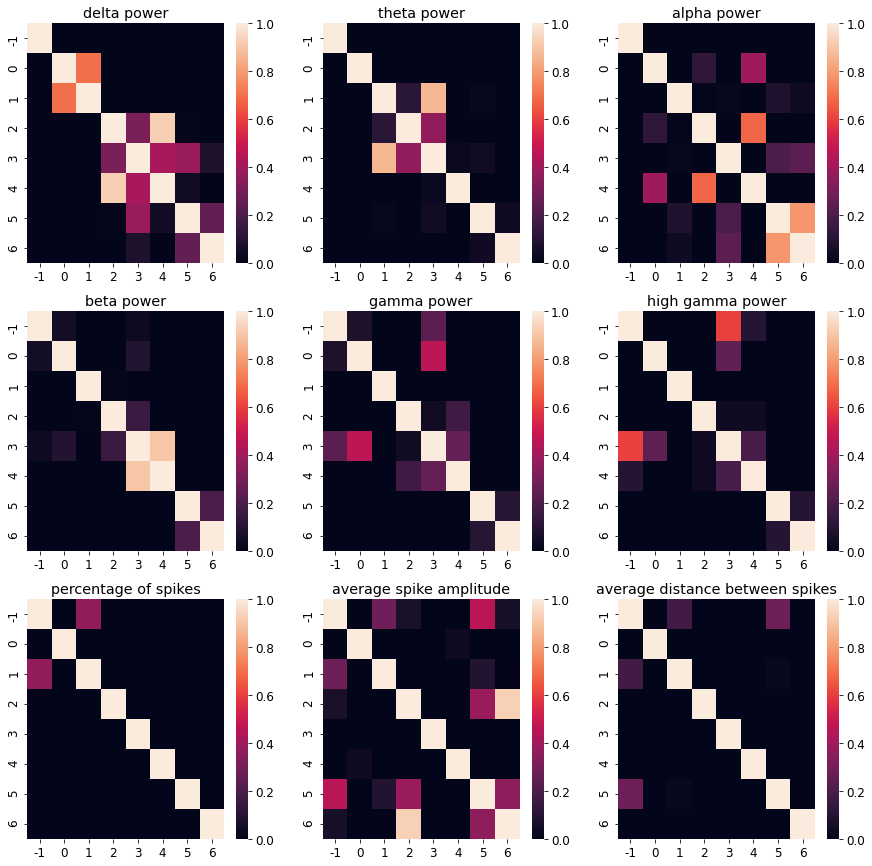

In [47]:
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
for i, x in enumerate(pValsMatrix):
    t = (i//3, i%3)
    sns.heatmap(x, xticklabels=np.unique(dfPresses['cond']), yticklabels=np.unique(dfPresses['cond']), ax=axs[t])
    axs[t].set_title(featureNames[i])

In [48]:
for x in pValsMatrix:
    print(np.mean([i for i in pd.core.common.flatten(x) if (not i == float('inf') and not i == 1)]))

0.11154566779279175
0.05296177747909557
0.09218426282380239
0.05152330820835264
0.048477323931642516
0.0469865076718915
0.013258576678305229
0.09571682409056127
0.0171588020194411


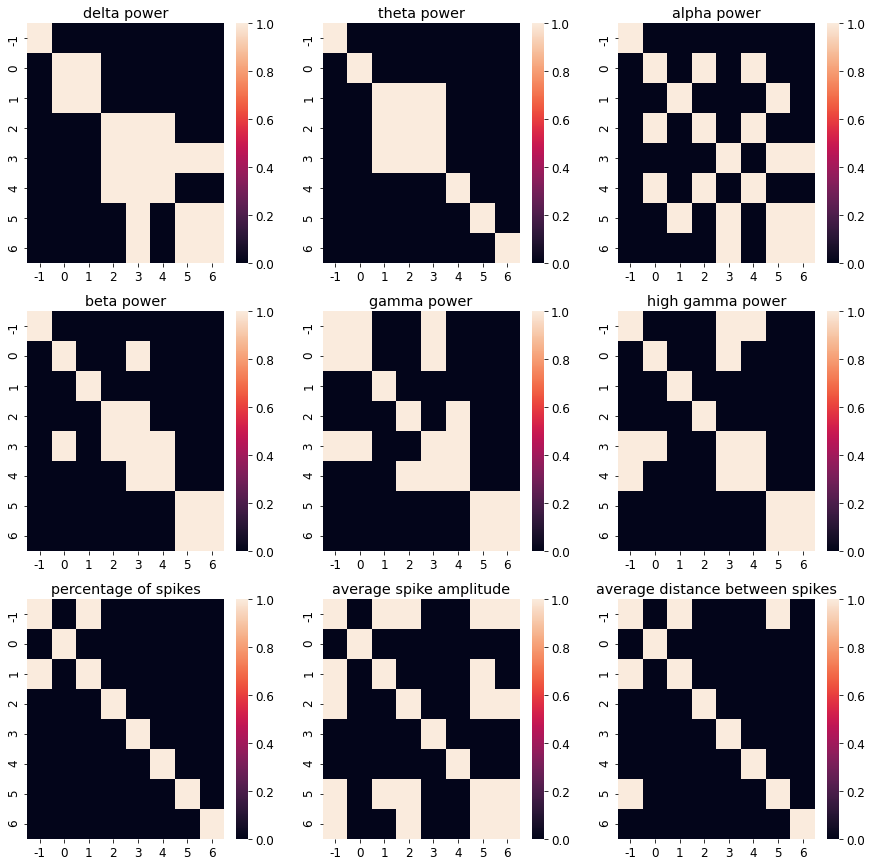

In [49]:
pValsMatrixBinary = np.copy(pValsMatrix)
for i in range(len(pValsMatrixBinary)):
    for j in range(len(pValsMatrixBinary[i])):
        for k in range(len(pValsMatrixBinary[i][j])):
            if pValsMatrixBinary[i][j][k] > 0.05:
                pValsMatrixBinary[i][j][k] = 1
            else:
                pValsMatrixBinary[i][j][k] = 0

fig, axs = plt.subplots(3, 3, figsize = (15, 15))
for i, x in enumerate(pValsMatrixBinary):
    t = (i//3, i%3)
    sns.heatmap(x, xticklabels=np.unique(dfPresses['cond']), yticklabels=np.unique(dfPresses['cond']), ax=axs[t])
    axs[t].set_title(featureNames[i])

In [50]:
totalPValMatrix = []
for cond1 in np.unique(dfPresses['cond']):
    x = []
    for cond2 in np.unique(dfPresses['cond']):
        v1 = list(pd.core.common.flatten(features[np.where(labels==cond1)[0]]))
        v2 = list(pd.core.common.flatten(features[np.where(labels==cond2)[0]]))

        x.append(t_test(v1, v2, cond1, cond2, False))
    totalPValMatrix.append(x)

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWar

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/Users/anirudhnatarajan/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWar

<AxesSubplot:>

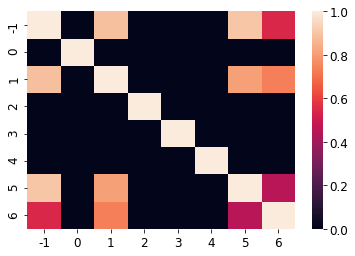

In [51]:
sns.heatmap(totalPValMatrix, xticklabels=np.unique(dfPresses['cond']), yticklabels=np.unique(dfPresses['cond']))

In [52]:
arr = averagedBands
dtwVals = np.zeros(len(arr))
for i in range(len(arr)):
    dtwVals[i] = fastdtw(arr[i][0], arr[i][1], dist=euclidean)[0]
    print(str(dtwVals[i]) + " " + band_names[i])

0.05546253758272536 delta
0.014283057585618696 theta
0.007722994289593798 alpha
0.006826696780726056 beta
0.0038616282009037136 gamma
0.002186079242809363 high gamma


In [53]:
x1 = arr[3][0]
x2 = arr[3][1]
distance, warp_path = fastdtw(x1, x2, dist=euclidean)
print(distance)

0.006826696780726056


In [54]:
# fig, ax = plt.subplots(figsize=(100, 75))

# fig.patch.set_visible(False)
# # ax.axis('off')

# for [map_x, map_y] in warp_path:
#     ax.plot([map_x, map_y], [x1[map_x], x2[map_y]], '-k')

# ax.plot(x1, color='blue', marker='o', markersize=10, linewidth=5)
# ax.plot(x2, color='red', marker='o', markersize=10, linewidth=5)
# ax.tick_params(axis="both", which="major", labelsize=18)

In [55]:
# featuresMod = features[np.where(labels != 3)[0]]
# labelsMod = labels[np.where(labels != 3)[0]]
featuresMod = features
labelsMod = labels

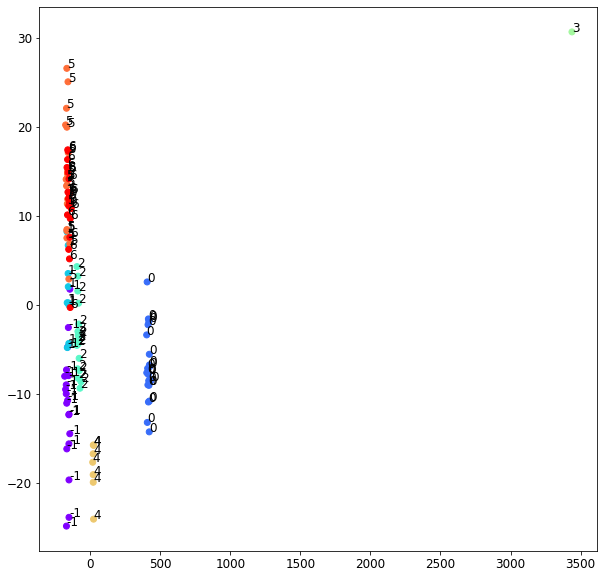

In [56]:
pca = PCA(n_components=3)
pca.fit(featuresMod,labelsMod)
X_embedded = pca.fit_transform(featuresMod, labelsMod)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=labelsMod, marker='o', cmap='rainbow')
zipped = list(zip(X_embedded[:,0], X_embedded[:,1]))
for i in range(len(labelsMod)):
    ax.annotate(labelsMod[i], xy=zipped[i])

trace = go.Scatter3d(
    x = X_embedded[:,0],
    y = X_embedded[:,1],
    z = X_embedded[:,2],
    customdata = labels,
    mode = 'markers',
    marker = dict(size = 4,
                  color = labelsMod,
                  colorscale = 'rainbow'),
    hovertemplate = 'cond %{customdata}<extra></extra>'
)
fig = go.Figure(data = [trace])
fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 116 samples in 0.000s...
[t-SNE] Computed neighbors for 116 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 116 / 116
[t-SNE] Mean sigma: 13.008713
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.263355
[t-SNE] KL divergence after 1000 iterations: 0.253388
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 116 samples in 0.022s...
[t-SNE] Computed neighbors for 116 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 116 / 116
[t-SNE] Mean sigma: 9.993456
[t-SNE] KL divergence after 250 iterations with early exaggeration: 131.998718
[t-SNE] KL divergence after 1000 iterations: 2.244679


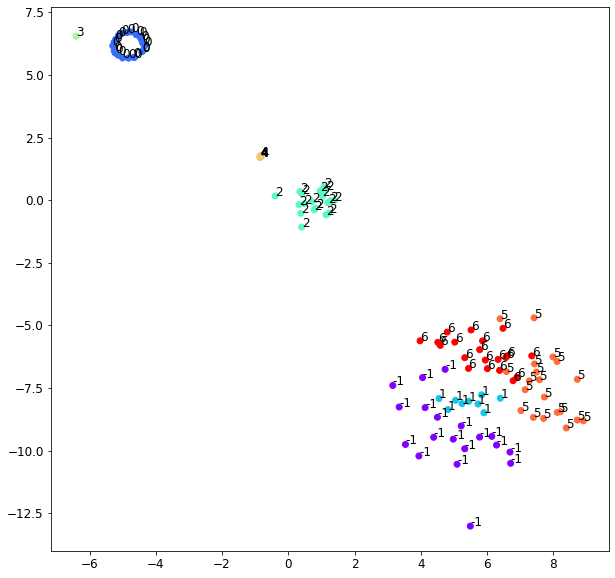

In [57]:
X_embedded = TSNE(n_components=2, verbose=1, random_state=12).fit_transform(features, labels)
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, marker='o', cmap='rainbow')

zipped = list(zip(X_embedded[:,0], X_embedded[:,1]))
for i in range(len(labels)):
    ax.annotate(labels[i], xy=zipped[i])

X_embedded = TSNE(n_components=3, verbose=1, perplexity=10, random_state=12).fit_transform(features, labels)
trace = go.Scatter3d(
    x = X_embedded[:,0],
    y = X_embedded[:,1],
    z = X_embedded[:,2],
    customdata = labels,
    mode = 'markers',
    marker = dict(size = 4,
                  color = labels,
                  colorscale = 'rainbow'),
    hovertemplate = 'cond %{customdata}<extra></extra>'
)
fig = go.Figure(data = [trace])
fig.show()

In [58]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import neighbors
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [59]:
# clf = svm.SVC()
clf = RandomForestClassifier(n_estimators=100)
# clf = ExtraTreesClassifier()
# clf = DecisionTreeClassifier()
# clf = GradientBoostingClassifier()
# clf = BaggingClassifier()
# clf = BaggingClassifier(RandomForestClassifier(n_estimators=100))
# clf = neighbors.KNeighborsClassifier()
# clf = SGDClassifier()
# clf = MLPClassifier()
# clf = GaussianNB()
# clf = LogisticRegression()
# clfs = [svm.SVC(), RandomForestClassifier(n_estimators=100), ExtraTreesClassifier(),
#        DecisionTreeClassifier(), GradientBoostingClassifier(), BaggingClassifier(),
#        BaggingClassifier(RandomForestClassifier(n_estimators=100)), neighbors.KNeighborsClassifier(),
#        SGDClassifier(), MLPClassifier(), GaussianNB(), LogisticRegression()]

In [60]:
clfAccs = []
for clf in [clf]:
    acc = []
    wrong = []
    for j in range(100):
        if j%10==0:
            print(j)
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33)
        clf.fit(X_train, y_train)
        correct = 0
        for i in range(len(X_test)):
            pred = clf.predict([X_test[i]])
            if pred == y_test[i]:
                correct += 1
            else:
                wrong.append([pred, y_test[i]])
        acc.append(correct/len(X_test))
    clfAccs.append(acc)

0
10
20
30
40
50
60
70
80
90


In [61]:
for x in clfAccs:
    print(np.mean(x))

0.978974358974359


In [62]:
def getFeature(index, n):
    ch = index//n
    f = featureNames[index%n]
    return "channel " + str(chs[ch]+1) + " " + f

In [63]:
n = len(featureNames)
imp = clf.feature_importances_
impDesc = []
for i, x in enumerate(imp):
    impDesc.append([x, getFeature(i,n)])
sorted(impDesc, reverse=True)

[[0.0200691512153407, 'channel 54 high gamma power'],
 [0.017931371011077748, 'channel 54 gamma power'],
 [0.0167937080035953, 'channel 61 beta power'],
 [0.016750787704509145, 'channel 61 gamma power'],
 [0.01645652545261417, 'channel 54 delta power'],
 [0.014730905905279484, 'channel 60 percentage of spikes'],
 [0.014091418424993058, 'channel 18 average distance between spikes'],
 [0.013309678273942395, 'channel 64 percentage of spikes'],
 [0.013170740905424494, 'channel 61 high gamma power'],
 [0.012780968378248053, 'channel 61 alpha power'],
 [0.012327691708158403, 'channel 61 average distance between spikes'],
 [0.012256302153388066, 'channel 54 beta power'],
 [0.011202472419905875, 'channel 21 percentage of spikes'],
 [0.011159821324114012, 'channel 29 percentage of spikes'],
 [0.010869452921636545, 'channel 55 gamma power'],
 [0.01061091833577, 'channel 61 average spike amplitude'],
 [0.009780379863556928, 'channel 34 percentage of spikes'],
 [0.009660967762079576, 'channel 6 pe

<AxesSubplot:>

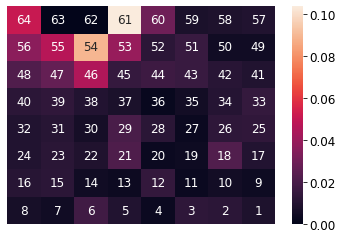

In [64]:
impCh = []
i = 0
for j in range(64):
    if j not in (63 - stimChannels):
        impCh.append(np.sum(imp[::-1][i*n:i*n+n]))
        i+=1
    else:
        impCh.append(0)
impCh = np.array(impCh)
l = np.arange(1,65)[::-1].reshape((8,8))
sns.heatmap(impCh.reshape((8,8)), annot=l, xticklabels=False, yticklabels=False)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

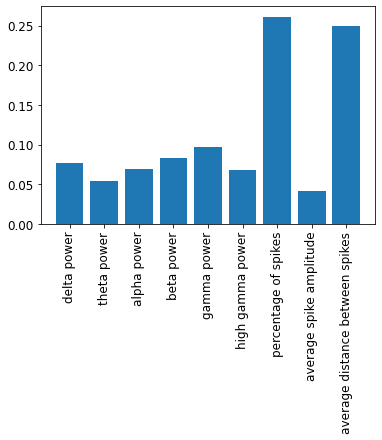

In [65]:
impF = np.array([np.sum(imp[i::n]) for i in range(n)])
plt.bar(featureNames, impF)
plt.xticks(rotation='vertical')

In [66]:
wrongPairs = {}
for x in wrong:
    if (x[0][0],x[1]) in wrongPairs:
        wrongPairs[(x[0][0],x[1])] = wrongPairs[(x[0][0],x[1])] + 1
    elif (x[1], x[0][0]) in wrongPairs:
        wrongPairs[(x[1],x[0][0])] = wrongPairs[(x[1],x[0][0])] + 1
    else:
        wrongPairs[(x[0][0],x[1])] = 1

In [67]:
wrongPairs

{(5, 6): 26, (-1, 1): 5, (0, 3): 38, (2, 4): 13}